# Missão 5 - SVM - Comparar diferentes configurações de SVM.

Utilizando o conjunto de dados Glass (https://archive.ics.uci.edu/ml/datasets/glass+identification).

Grupo: Hérikles Cordeiro e Juliana Loureiro - Repositório:  https://github.com/HeriklesVinicyus/Missao-05-SVM

- Apresentar um relatório curto sobre os desempenhos médios (no treinamento, validação e teste), discussões e conclusões obtidas.

## **Introdução Support Vector Machine (SVM)**

Uma máquina de vetores de suporte (SVM) é um método de aprendizagem para problemas de classificação considerando duas categorias. Uma SVM desenvolve o modelo tomando as entradas de treinamento, mapeando-as no espaço multidimensional e utilizando regressão para encontrar um hiperplano (que é uma superfície num espaço de $n$ dimensões, o qual o separa em duas metades) que melhor separa duas classes de entradas. Uma vez que a máquina de vetores de suporte tenha sido treinada, ela é capaz de avaliar novas entradas em relação ao hiperplano divisor e classificá-las em uma entre duas categorias.

O benefício de utilizar SVM para extrair um padrão complexo dos dados é que não é necessário um conhecimento prévio acerca do comportamento dos dados. Dentre as características das máquinas de vetores de suporte é que elas são capazes de lidar com erros e ruídos nos dados. SVM são geralmente capazes de perceber o padrão nos dados e filtrar valores de dados atípicos e outras complexidades.

### SVM com margens rígidas [3]
As SVMs lineares com margens rígidas definem fronteiras lineares a partir de dados linearmente separáveis.  Seja T um conjunto de treinamento com n dados $x_{i}\in X$ e seus respectivos rótulos $y_{i}\in Y$, em que $X$ constitui o espaço dos dados e $Y = \{-1;+1\}$. $T$ é linearmente separável se é possível separar os dados das classes $+1$ e $-1$ por um hiperplano.

A equação de um hiperplano é representada por $$f(x)=w·x+b=0,$$
onde $w·x$ é o produto escalar entre os vetores $w$ e $x$, $w\in X$ é o vetor normal ao hiperplano descrito e $\frac{b}{\|w\|}$ corresponde à distância do hiperplano em relação à origem, com $b \in \Re$. 

Essa equação dividi o espaço dos dados $X$ em duas regiões $w·x+b>0$ e $w·x+b<0$. Assim uma função sinal $g(x) = sgn(f(x))$ pode ser utilizada na obtenção das classificações, cujo valor $+1$ é obtido se $w·x+b>0$, $-1$ se $w·x+b<0$.

### SVM com margens suaves [3]
Em situações reais, é difícil encontrar aplicações cujos dados sejam linearmente separáveis. Isso se deve a diversos fatores, entre eles a presença de ruídos e outliers nos dados ou à própria natureza do problema, que pode ser não linear. Neste cenário o problema de SVM linear é extendido para lidar com esse problema.

Para realizar essa tarefa, permite-se que alguns dados possam violar a restrição de que não pode haver dados de treinamento entre as margens de separação das classes. Para isso são introduzidas variáveis de folga $\xi$, para todo $i = 1,...,n$. Essas variáveis relaxam as restrições impostas ao problema de otimização.
$$
y_{i}(w·x_{i}+b)\geq 1−\xi_{i}, \xi_{i}>0,\forall i = 1,...,n
$$

A aplicação desse procedimento suaviza as margens do classificador linear, permitindo que alguns dados permaneçam entre os hiperplanos e também a ocorrência de alguns erros de classificação. Por esse motivo, as SVMs obtidas neste caso também podem  ser referenciadas como SVMs com margens suaves.

Um erro no conjunto de treinamento é indicado por um valor de $\xi_{i}$ maior que 1. Logo,a soma dos $\xi_{i}$ representa um limite no número de erros de treinamento. Para levar em consideração esse termo, a função objetivo é reformulada, incluindo um termo constante $C$, termo de regularização, que impõe um peso à minimização dos erros no conjunto de treinamento em relação a minimização da complexidade do modelo. A presença do termo $\sum_{i=1}^{n} \xi_{i}$ no problema de otimização também pode ser vista como uma minimização de erros marginais, pois um valor de $\xi_{i} \in (0,1]$ indica um dado entre as margens. 

In [1]:
"""
Importação das bibliotecas usadas no Notebook
"""
import numpy as np
import pandas as pd
import sklearn.preprocessing as pre
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.utils.multiclass import class_distribution, unique_labels

#Pré-pocessamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

#Métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Validação crizada
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

#Modelos de Classificação
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

## Explorando os dados

O conjunto de dados 'Glass' é contituído de 214 exemplos com 9 variáveis numéricas (continuas) e a variável alvo 'Type_of_glass' contém as respectivas classes (1 2 3 5 6 7).

Através da análise descritiva dos dados, pode-se verificar que as variáveis de entrada possuem diferentes escalas e isso pode ser um problema para modelos de SVM. 

Um outro aspecto identificado na tarefa de exploração é que existe correlação $(0.8)$ entre 2 das variáveis de entrada `RI` e `Ca`, que pode ser visualizado no plot da matriz de correlação. No entanto, o problema aqui tratado, refere-se ao uso de SVM não linear, e nesse cenário a correlação entre as features não interferem no modelo, devido ao uso do *kernel trick*.


### Avaliar esse aspecto melhor
Portanto, a literatura sugere remover uma dessas variáveis, pelo simples motivo que ambas possuem o mesmo efeito sobre a variável de interesse (alvo). Portanto, variáveis correlacionadas não contribuem para melhorar o modelo, além disso menos variáveis resultam em melhor performance de aprendizado e modelos mais simples [4].

In [2]:
"""
Carregando os dados
"""
id_col = ['RI', 'Na', 'Mg', 'Al', 'Si','K', 'Ca', 'Ba', 'Fe', 'Type_of_glass']
df = pd.read_csv('base/glass.csv',  encoding='UTF-8',sep=',', names=id_col, index_col=0)

#print dados
print(df)

          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type_of_glass
1    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0              1
2    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0              1
3    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0              1
4    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0              1
5    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0              1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...            ...
210  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0              7
211  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0              7
212  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0              7
213  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0              7
214  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0              7

[214 rows x 10 columns]


In [3]:
"""
Separanda as classes
"""
r_classes = unique_labels(df['Type_of_glass'])
print('Rotulos da classe: ',r_classes)

Rotulos da classe:  [1 2 3 5 6 7]


In [4]:
print('Alguns dados estatisticos')
print(df.describe())

Alguns dados estatisticos
               RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516523   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe  Type_of_glass  
count  214.000000  214.000000  214.000000     214.000000  
mean     8.956963    0.175047    0.057009       2.780374  
std      1.423153    0.497219    0.097439       2.103739  
min     

#### Computa o coeficiente de correlação entre as variáveis e apresenta os resultados graficamente.

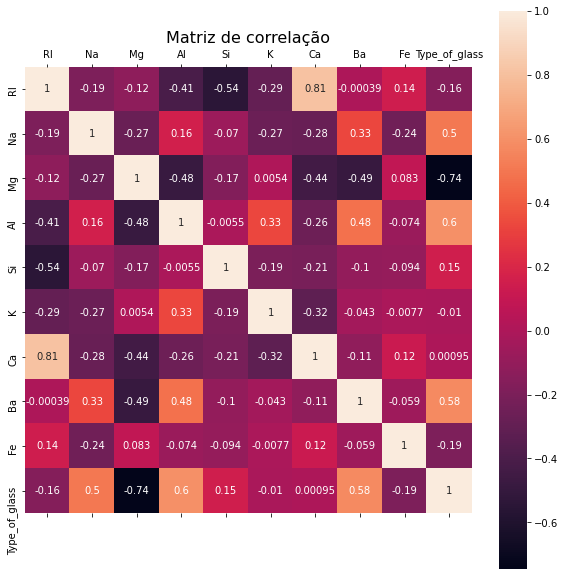

In [5]:
plt.rcParams["figure.figsize"] = (15,10)
plt.matshow(df.corr())
sn.heatmap(df.corr(), annot=True)
plt.title('Matriz de correlação', fontsize=16);
plt.show()

## Avaliação diferentes classificadores, sem realizar pré-processamento dos dados
O intuito deste estudo é apresentar o desempenho do classificador SVM executando diferentes configurações dos parâmetros. Para realizar essa tarefa, foi usado o pacote do [Scikit-learn](https://scikit-learn.org/stable/index.html "Home do scikit-learn").

Inicialmente foram implementados os classificadores:  
 - Support vector machine for classification
 - K Nearest Neighbors
 - Gaussian Naive Bayes
 - Regressão logística

sem nenhuma parametrização e sem realizar o pre-processamento dos dados. Em seguida, analisaremos o ganho para o SVM na tarefa de classificação, quando é realizado o pre-processamento dos dados, a parametrização do modelo e o uso de diferentes funções kernel:
* linear: $(x,x^{'})$;
* polynomial: $(\gamma(x,x^{'}) + r)^{d}$, onde $d$ é o grau do polinômio e $r$ coeficiente 0;
* rbf: $exp(-\gamma \|x-x^{'}\|^2)$, onde $\gamma$ deve ser maior do que zero;
* sigmoid: $tanh(\gamma(x,x^{'}) + r)$ , onde $r$ é o coeficiente 0.

Ao treinar um SVM com o kernel Radial Basis Function (`rbf`), dois parâmetros devem ser considerados: C e gama (aqui será usado o padrão do modelo). O parâmetro C, comum a todos os kernels SVM, compensa a classificação incorreta dos exemplos de treinamento pela simplicidade da superfície de decisão. Um C baixo torna a superfície de decisão suave, enquanto um C alto visa classificar todos os exemplos de treinamento corretamente. Gamma define quanta influência um único exemplo de treinamento tem. Quanto maior for a gama, mais próximos os outros exemplos devem estar para serem afetados.

A escolha adequada de C é crítica para o desempenho do SVM.

Aplicando os modelos aos dados brutos, verificamos que o `K-NN` (acurácia 0.74) e a `Regressão Logística` (acurácia 0.65) obtiveram os melhores resultados, pois não dependem da escala das variáveis de entrada. No entanto, os modelos `SVM` (0.30) e `Gaussian NB` (0.49) não apresentaram resultados satisfatórios para a tarefa de classificação dos dados. Pois, possuem baixa acurácia, indicando que o modelo não é capaz de classificar corretamente os dados. 

No caso do `SVM`, nosso foco neste estudo, isto ocorreu porque o processo de otimização deste método, ocorre através da minimização do vetor de decisão $w$. O hiperplano ótimo é influenciado pela escala das variáveis de entrada e portanto é recomendado padronizar as variáveis, deixando-as com média 0 e variância 1.

Também realizamos a avaliação dos modelos com os dados normalizados conforme os métodos:
* Min-max: $z = \frac{x-min(x)}{max(x)-min(x)}$;

* Pela magnitude do vetor: $\hat{u} = \frac{\vec u}{\|\vec u\|}$. Onde $\vec u = (x_{1},...,x_{p})$, e $ \|\vec u\| = \sqrt{ \sum_{i=1}^{p}{x_{i}^{2}}}$.

In [6]:
"""
Separadando as feature das classes da base de dados
"""
#feature
X = df.iloc[:, 0:9].values
#classes
y = df.iloc[:, -1].values

#separação da base em Treinamento × Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=415)

In [7]:
#Classificadores com os paremetros no patrao (arrumar outro nome)
clf = svm.SVC()
knn = KNeighborsClassifier()
gnb = GaussianNB()
reg = LogisticRegression()

#Colocar um nome
clf.fit(X_train, y_train)
knn.fit(X_train, y_train)
gnb.fit(X_train, y_train)
reg.fit(X_train, y_train)
print('Classificadores treinados')

Classificadores treinados


#### Desempenho dos modelos sem pré-processamento ou ajuste de parâmetros 

In [8]:
#Predicao
y_svm = clf.predict(X_test)
y_knn = knn.predict(X_test)
y_gnb = gnb.predict(X_test)
y_reg = reg.predict(X_test)

#### Acurácia dos modelos iniciais

In [9]:
#Acuracias dos modelos sem pre-processamento
print('K-NN: ', accuracy_score(y_test, y_knn))
print('Gaussian NB: ', accuracy_score(y_test, y_gnb))
print('Regresao logistica (lr): ', accuracy_score(y_test, y_reg))
print('SVM: ', accuracy_score(y_test, y_svm))

K-NN:  0.7441860465116279
Gaussian NB:  0.4883720930232558
Regresao logistica (lr):  0.6511627906976745
SVM:  0.3023255813953488


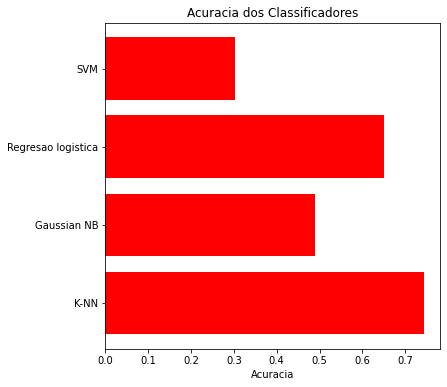

In [10]:
## Grafico de acuracia
nome_classificadores = ['K-NN', 'Gaussian NB', 'Regresao logistica','SVM']
metricas = [accuracy_score(y_test, y_knn), accuracy_score(y_test, y_gnb), accuracy_score(y_test, y_reg), accuracy_score(y_test, y_svm)]

plt.rcParams["figure.figsize"] = (6,6)
plt.barh(nome_classificadores, metricas, color='red')
plt.xlabel('Acuracia')
plt.title('Acuracia dos Classificadores')
plt.show()

## Pré-processamento de dados

Conforme citado anteriormente, realizamos 3 tarefas de tratamento dos dados, padronização e dois tipos de normalização. O conjunto de dados não apresenta valores ausentes, então nehuma ação foi realizada nesse sentido.

1. segundo a base de dados, não tem Missing Values(dados ausentes)
1. Não existe dados categoricos, alem das classes
1. Normalização (MinMax, normalização pela magnitude)
1. Padronização (média e desvio padrão).


#### Normalização dos dados por min-max

In [11]:
#Dados normalizados
X_min_max = MinMaxScaler().fit_transform(X.copy())
X_min_max = pd.DataFrame(X_min_max, columns=id_col[0:9])

#separação da base min_max em Treinamento × Teste 
X_min_max_train, X_min_max_test, y_min_max_train, y_min_max_test = train_test_split(X_min_max, y, test_size=0.33, random_state=4135)

print('Dados normalizados (Min_max) \n',X_min_max)

Dados normalizados (Min_max) 
            RI        Na        Mg        Al        Si         K        Ca  \
0    0.432836  0.437594  1.000000  0.252336  0.351786  0.009662  0.308550   
1    0.283582  0.475188  0.801782  0.333333  0.521429  0.077295  0.223048   
2    0.220808  0.421053  0.790646  0.389408  0.567857  0.062802  0.218401   
3    0.285777  0.372932  0.821826  0.311526  0.500000  0.091787  0.259294   
4    0.275241  0.381955  0.806236  0.295950  0.583929  0.088567  0.245353   
..        ...       ...       ...       ...       ...       ...       ...   
209  0.223003  0.512782  0.000000  0.806854  0.500000  0.012882  0.348513   
210  0.250219  0.630075  0.000000  0.529595  0.580357  0.000000  0.276022   
211  0.417032  0.545865  0.000000  0.538941  0.644643  0.000000  0.279740   
212  0.235294  0.548872  0.000000  0.514019  0.678571  0.000000  0.283457   
213  0.261633  0.526316  0.000000  0.557632  0.633929  0.000000  0.296468   

           Ba   Fe  
0    0.000000  0.0  
1 

### Normalização dos dados pela magnitude

In [12]:
#
X_norm = normalize(X.copy(), norm='l2')
X_norm = pd.DataFrame(X_norm, columns=id_col[0:9])
#separação da base min_max em Treinamento × Teste 
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y, test_size=0.33, random_state=4215)

print('Dados normalizados (Normalization) \n',X_norm)

Dados normalizados (Normalization) 
            RI        Na        Mg        Al        Si         K        Ca  \
0    0.020625  0.184956  0.060884  0.014916  0.973323  0.000814  0.118648   
1    0.020350  0.186259  0.048274  0.018237  0.975277  0.006437  0.104997   
2    0.020282  0.180987  0.047487  0.020600  0.976368  0.005217  0.104071   
3    0.020404  0.177605  0.049611  0.017344  0.976220  0.007663  0.110515   
4    0.020279  0.177341  0.048378  0.016571  0.976647  0.007350  0.107848   
..        ...       ...       ...       ...       ...       ...       ...   
209  0.020319  0.189493  0.000000  0.038596  0.973063  0.001072  0.123023   
210  0.020198  0.198674  0.000000  0.026499  0.972861  0.000000  0.111854   
211  0.020182  0.190587  0.000000  0.026810  0.974438  0.000000  0.112017   
212  0.020077  0.190373  0.000000  0.025683  0.974505  0.000000  0.112265   
213  0.020151  0.189014  0.000000  0.027628  0.974424  0.000000  0.114498   

           Ba   Fe  
0    0.000000  0.

#### Padronização dos dados - pela média e desvio padrão

In [13]:
# 
X_stand = pre.StandardScaler().fit_transform(X.copy())
X_stand = pd.DataFrame(X_stand, columns=id_col[0:9])

#separação da base padronizada em Treinamento × Teste 
X_stand_train, X_stand_test, y_stand_train, y_stand_test = train_test_split(X_stand, y, test_size=0.33, random_state=4135)

print('Dados Padronizados\n', X_stand)

Dados Padronizados
            RI        Na        Mg        Al        Si         K        Ca  \
0    0.872868  0.284953  1.254639 -0.692442 -1.127082 -0.671705 -0.145766   
1   -0.249333  0.591817  0.636168 -0.170460  0.102319 -0.026213 -0.793734   
2   -0.721318  0.149933  0.601422  0.190912  0.438787 -0.164533 -0.828949   
3   -0.232831 -0.242853  0.698710 -0.310994 -0.052974  0.112107 -0.519052   
4   -0.312045 -0.169205  0.650066 -0.411375  0.555256  0.081369 -0.624699   
..        ...       ...       ...       ...       ...       ...       ...   
209 -0.704815  0.898681 -1.865511  2.881125 -0.052974 -0.640968  0.157088   
210 -0.500178  1.856097 -1.865511  1.094342  0.529374 -0.763919 -0.392276   
211  0.754046  1.168721 -1.865511  1.154570  0.995252 -0.763919 -0.364103   
212 -0.612399  1.193270 -1.865511  0.993960  1.241133 -0.763919 -0.335931   
213 -0.414363  1.009152 -1.865511  1.275028  0.917606 -0.763919 -0.237327   

           Ba        Fe  
0   -0.352877 -0.586451  
1  

### Resultados treinamento dos modelos com os dados normalizados min-max

Observa-se que após a normalização por min-max os resultados para o modelo SVM foram significativamente superiores quando comparado com o modelo sem tratamento dos dados. Por outro lado, os demais modelos apresentaram queda de desempenho.

In [14]:
#Treinamento com base min_max
# Colocar um nome
clf.fit(X_min_max_train, y_min_max_train)
knn.fit(X_min_max_train, y_min_max_train)
reg.fit(X_min_max_train, y_min_max_train)
gnb.fit(X_min_max_train, y_min_max_train)
print('Classificadores treinados para os dados X_min_max')

Classificadores treinados para os dados X_min_max


In [15]:
#predicao com base min_max
#Colocar um nome aqui
y_min_max_svm = clf.predict(X_min_max_test)
y_min_max_knn = knn.predict(X_min_max_test)
y_min_max_reg = reg.predict(X_min_max_test)
y_min_max_gnb = gnb.predict(X_min_max_test)

#Acuracias dos modelos sem pre-processamento
print('k-NN\n', classification_report(y_min_max_test, y_min_max_knn))
print('-'*60,'\n')
print('Gaussian NB\n', classification_report(y_min_max_test, y_min_max_gnb))
print('-'*60,'\n')
print('Regrecao logistica\n', classification_report(y_min_max_test, y_min_max_reg))
print('-'*60,'\n')
print('SVM\n', classification_report(y_min_max_test, y_min_max_svm))

k-NN
               precision    recall  f1-score   support

           1       0.67      0.76      0.71        21
           2       0.58      0.78      0.67        23
           3       0.00      0.00      0.00         9
           5       0.67      0.25      0.36         8
           6       0.50      1.00      0.67         2
           7       0.67      0.75      0.71         8

    accuracy                           0.62        71
   macro avg       0.51      0.59      0.52        71
weighted avg       0.55      0.62      0.57        71

------------------------------------------------------------ 

Gaussian NB
               precision    recall  f1-score   support

           1       0.75      0.14      0.24        21
           2       0.67      0.17      0.28        23
           3       0.20      0.89      0.32         9
           5       0.75      0.38      0.50         8
           6       0.50      1.00      0.67         2
           7       0.67      1.00      0.80       

### Resultados treinamento dos modelos com dados normalizados pela magnitude

Esse tipo de normalização dos dados não agregou valor no ajuste dos modelos de SVM e Regressão, pois os resultados estão significativamente inferiores a normalização min-max.


In [16]:
#Treinamento com base normalizada
# Colocar um nome
clf.fit(X_norm_train, y_norm_train)
knn.fit(X_norm_train, y_norm_train)
reg.fit(X_norm_train, y_norm_train)
gnb.fit(X_norm_train, y_norm_train)
print('Classificadores treinados para os dados X_norm')

Classificadores treinados para os dados X_norm


In [17]:
#predicao com base min_max
#Colocar um nome aqui
y_norm_svm = clf.predict(X_norm_test)
y_norm_knn = knn.predict(X_norm_test)
y_norm_reg = reg.predict(X_norm_test)
y_norm_gnb = gnb.predict(X_norm_test)

#Acuracias dos modelos sem pre-processamento
print('k-NN\n', classification_report(y_norm_test, y_norm_knn))
print('-'*60,'\n')
print('Gaussian NB\n', classification_report(y_norm_test, y_norm_gnb))
print('-'*60,'\n')
print('Regrecao logistica\n', classification_report(y_norm_test, y_norm_reg))
print('-'*60,'\n')
print('SVM\n', classification_report(y_norm_test, y_norm_svm))

k-NN
               precision    recall  f1-score   support

           1       0.63      0.79      0.70        24
           2       0.67      0.67      0.67        24
           3       0.00      0.00      0.00         4
           5       0.50      0.75      0.60         4
           6       0.00      0.00      0.00         5
           7       0.89      0.80      0.84        10

    accuracy                           0.65        71
   macro avg       0.45      0.50      0.47        71
weighted avg       0.59      0.65      0.62        71

------------------------------------------------------------ 

Gaussian NB
               precision    recall  f1-score   support

           1       0.50      0.83      0.62        24
           2       0.25      0.04      0.07        24
           3       0.17      0.25      0.20         4
           5       0.22      0.50      0.31         4
           6       0.71      1.00      0.83         5
           7       1.00      0.50      0.67       

### Resultados treinamento dos modelos com dados padronizados

A padronização dos dados causa efeito significativo no modelo SVM, cuja acurácia atingiu o melhor resultado (0.63) até o momento, para este método. No entanto, para os demais métodos padronizar os dados não agregou valor ao modelo.

Inclusive, para os métodos Regressão e $K$-NN, trabalhar com os dados originais, produziu o melhor resultado.



In [18]:
#Treinamento com dados padronizados
clf.fit(X_stand_train, y_stand_train)
knn.fit(X_stand_train, y_stand_train)
reg.fit(X_stand_train, y_stand_train)
gnb.fit(X_stand_train, y_stand_train)
print('Classificadores treinados para os dados X_stand')

Classificadores treinados para os dados X_stand


In [19]:
#predicao com dados padronizados
y_stand_svm = clf.predict(X_stand_test)
y_stand_knn = knn.predict(X_stand_test)
y_stand_reg = reg.predict(X_stand_test)
y_stand_gnb = gnb.predict(X_stand_test)

#Acuracias dos modelos para os dados padronizados
print('k-NN\n', classification_report(y_stand_test, y_stand_knn))
print('-'*60,'\n')
print('Gaussian NB\n', classification_report(y_stand_test, y_stand_gnb))
print('-'*60,'\n')
print('regressao logistica\n', classification_report(y_stand_test, y_stand_reg))
print('-'*60,'\n')
print('SVM\n', classification_report(y_stand_test, y_stand_svm))

k-NN
               precision    recall  f1-score   support

           1       0.59      0.76      0.67        21
           2       0.56      0.65      0.60        23
           3       0.00      0.00      0.00         9
           5       0.50      0.25      0.33         8
           6       0.67      1.00      0.80         2
           7       0.70      0.88      0.78         8

    accuracy                           0.59        71
   macro avg       0.50      0.59      0.53        71
weighted avg       0.51      0.59      0.54        71

------------------------------------------------------------ 

Gaussian NB
               precision    recall  f1-score   support

           1       0.67      0.10      0.17        21
           2       0.67      0.17      0.28        23
           3       0.19      0.89      0.31         9
           5       0.75      0.38      0.50         8
           6       0.50      1.00      0.67         2
           7       0.67      1.00      0.80       

### Validação Cruzada

A seguir serão apresentados os resultados do processo de validação cruzada utilizando o método k-fold com k=5 e 10 repetições.
Para o método SVM na tarefa de classificação, considerando diferentes funções kernel (linear, RBF, sigmoid e polinomial).

Os valores utilizados para o paramêtro C foram {2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131,137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199}.

Vale destacar, que os modelos foram avaliados utilizando os dados brutos, normalizados e padronizados.


In [20]:
#K-fold
n_splits=5
n_repeats=10
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2652124)

In [21]:
def K_fold(clf,X_, y_, axis_=None, metrica='accuracy'):
    ind_k_fold = rkf.split(X_)
    temp = []
    for train_index, test_index in ind_k_fold:
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = y_[train_index], y_[test_index]

        clf.fit(X_train,y_train)
        y_np = clf.predict(X_test)
        scores_svm = classification_report(y_test,y_np,output_dict=True) 
        temp.append(scores_svm[metrica])
    return np.array(temp).reshape(n_splits,n_repeats).mean(axis=axis_)

def valida_paremetros(C:list, X_,y_,metrica='accuracy',kernel_='rbf', degree_=3, axis_=None):
    resp = []
    if len(C)>1:
        for x in C:
            clf = svm.SVC(C=x,kernel=kernel_,degree=degree_)
            resp.append([x, K_fold(clf,X_,y_,axis_,metrica)])
        return np.array(resp)
    elif len(degree_)>1 and kernel_=='poly':
        for x in degree_:
            clf = svm.SVC(C=C[0],kernel=kernel_,degree=x)
            resp.append([x, K_fold(clf,X_,y_,axis_,metrica)])
        return np.array(resp)
    else:
        clf = svm.SVC(C=C,kernel=kernel_,degree=x)
        return [x, K_fold(clf,X_,y_,axis_,metrica)]

### SVM - Kernel RBF

#### Tarefa de validação cruzada k-fold com dados brutos - kernel RBF
- obs.: Existe uma mŕtrica indica para o paremetor C são os valores do array {5^-3,5^-2,5^-1,1,5,5^2,5^3} [5](https://towardsdatascience.com/effect-of-feature-standardization-on-linear-support-vector-machines-13213765b812), porém não mostrou resultados para o kernel polinomial em tempo hábil.

In [22]:
# Para esse trabalho parte vamos usar as base de treimento(onde seré dividido no k-fold) e test
C = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131,137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199]
#Treimando non-preprocessing
acuracias = pd.DataFrame(valida_paremetros(C,X_train,y_train,axis_=1), columns=['C', 'Acuracias'])
print(acuracias)

      C                                          Acuracias
0     2  [0.33613445378151263, 0.32731092436974796, 0.3...
1     3  [0.33613445378151263, 0.32731092436974796, 0.3...
2     5  [0.33613445378151263, 0.32731092436974796, 0.3...
3     7  [0.33613445378151263, 0.32731092436974796, 0.3...
4    11  [0.3420168067226891, 0.3302521008403362, 0.333...
5    13  [0.36260504201680677, 0.35084033613445376, 0.3...
6    17  [0.41512605042016804, 0.41495798319327737, 0.4...
7    19  [0.4178151260504202, 0.42075630252100843, 0.42...
8    23  [0.42932773109243694, 0.4264705882352942, 0.43...
9    29  [0.44084033613445384, 0.43235294117647066, 0.4...
10   31  [0.43226890756302516, 0.43235294117647066, 0.4...
11   37  [0.42369747899159665, 0.43235294117647055, 0.4...
12   41  [0.4207563025210083, 0.43235294117647055, 0.42...
13   43  [0.4207563025210083, 0.43235294117647066, 0.42...
14   47  [0.4207563025210083, 0.44109243697478995, 0.42...
15   53  [0.42369747899159665, 0.44983193277310923, 0.4.

#### Tarefa validação cruzada k-fold com dados normalizados min-max - Kernel RBF

In [23]:
acuracias_mm = pd.DataFrame(valida_paremetros(C,X_min_max_train.values,y_min_max_train,axis_=1), columns=['C', 'Acuracias'])
print(acuracias_mm)

      C                                          Acuracias
0     2  [0.6123152709359606, 0.6719211822660098, 0.682...
1     3  [0.6509852216748768, 0.679064039408867, 0.6891...
2     5  [0.6580049261083744, 0.7030788177339902, 0.682...
3     7  [0.668472906403941, 0.6822660098522167, 0.6929...
4    11  [0.6684729064039409, 0.6820197044334976, 0.692...
5    13  [0.6682266009852217, 0.6682266009852216, 0.685...
6    17  [0.6613300492610839, 0.6716748768472907, 0.678...
7    19  [0.6610837438423646, 0.6751231527093596, 0.682...
8    23  [0.6506157635467982, 0.6785714285714286, 0.692...
9    29  [0.6539408866995073, 0.6716748768472907, 0.689...
10   31  [0.6433497536945813, 0.675, 0.6858374384236453...
11   37  [0.6224137931034482, 0.6646551724137931, 0.682...
12   41  [0.6222906403940887, 0.6612068965517242, 0.682...
13   43  [0.6222906403940887, 0.6612068965517242, 0.692...
14   47  [0.6258620689655172, 0.6751231527093596, 0.689...
15   53  [0.6293103448275861, 0.6751231527093596, 0.685.

#### Tarefa validação cruzada k-fold com dados normalizados pela magnitude - Kernel RBF

In [24]:
acuracias_norm = pd.DataFrame(valida_paremetros(C,X_norm_train.values,y_norm_train,axis_=1), columns=['C', 'Acuracias'])
print(acuracias_norm)

      C                                          Acuracias
0     2  [0.30825123152709366, 0.31477832512315274, 0.3...
1     3  [0.30825123152709366, 0.31477832512315274, 0.3...
2     5  [0.30825123152709366, 0.31477832512315274, 0.3...
3     7  [0.30825123152709366, 0.31477832512315274, 0.3...
4    11  [0.30098522167487685, 0.31822660098522165, 0.3...
5    13  [0.3185960591133005, 0.33546798029556646, 0.32...
6    17  [0.3571428571428571, 0.4023399014778325, 0.366...
7    19  [0.37783251231527093, 0.40258620689655167, 0.3...
8    23  [0.4054187192118227, 0.4232758620689655, 0.405...
9    29  [0.4088669950738916, 0.41637931034482756, 0.41...
10   31  [0.40197044334975374, 0.41637931034482756, 0.4...
11   37  [0.4054187192118227, 0.4235221674876847, 0.412...
12   41  [0.40197044334975374, 0.4233990147783251, 0.41...
13   43  [0.40197044334975374, 0.4233990147783251, 0.41...
14   47  [0.40197044334975374, 0.4304187192118226, 0.43...
15   53  [0.4055418719211823, 0.42684729064039406, 0.43.

#### Tarefa validação cruzada k-fold com dados padronizados - Kernel RBF

In [25]:
acuracias_stand = pd.DataFrame(valida_paremetros(C,X_stand_train.values,y_stand_train,axis_=1), columns=['C', 'Acuracias'])
print(acuracias_stand)

      C                                          Acuracias
0     2  [0.6789408866995074, 0.6786945812807882, 0.706...
1     3  [0.6821428571428572, 0.685591133004926, 0.7102...
2     5  [0.6921182266009852, 0.6854679802955665, 0.713...
3     7  [0.6820197044334976, 0.6786945812807883, 0.699...
4    11  [0.6677339901477832, 0.6716748768472907, 0.675...
5    13  [0.6605911330049261, 0.6716748768472907, 0.668...
6    17  [0.6640394088669951, 0.6786945812807882, 0.668...
7    19  [0.6710591133004926, 0.6752463054187192, 0.668...
8    23  [0.6571428571428573, 0.6679802955665025, 0.668...
9    29  [0.656896551724138, 0.6572660098522166, 0.6720...
10   31  [0.663793103448276, 0.6607142857142857, 0.6756...
11   37  [0.6533251231527093, 0.6571428571428571, 0.679...
12   41  [0.6567733990147784, 0.6641625615763547, 0.682...
13   43  [0.6533251231527094, 0.6607142857142857, 0.682...
14   47  [0.6532019704433498, 0.6641625615763547, 0.682...
15   53  [0.6567733990147784, 0.6607142857142857, 0.679.

### Resultados da valiação cruzada para o modelo SVM com Kernel RBF

O gráfico a seguir apresenta os resultados da tarefa de validação cruzada para o SVM com kernel RBF, para cada valor do parâmetro $C$. Vale destacar, que o modelo ganha um desempenho significativo na tarefa de classificação, com a padronização dos dados de entrada. Esse modelo apresenta uma acurária com certa estabilidade ao longo da variação dos valores de $C$.


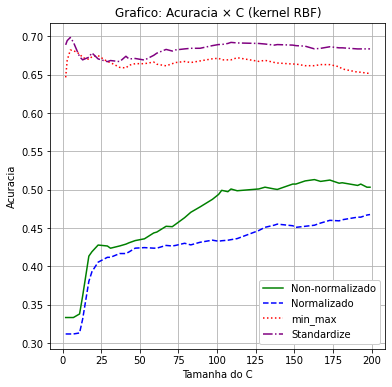

In [26]:
#Plot 
plt.plot(acuracias.iloc[:,0].values, [x.mean() for x in acuracias.iloc[:,1].to_numpy()], color='g', label='Non-normalizado')
plt.plot(acuracias_norm.iloc[:,0].values, [x.mean() for x in acuracias_norm.iloc[:,1].to_numpy()], color='b' , linestyle='--', label='Normalizado')
plt.plot(acuracias_mm.iloc[:,0].values, [x.mean() for x in acuracias_mm.iloc[:,1].to_numpy()], color='r',linestyle=':', label='min_max')

plt.plot(acuracias_stand.iloc[:,0].values, [x.mean() for x in acuracias_stand.iloc[:,1].to_numpy()], color='purple',linestyle='-.', label='Standardize')
plt.ylabel('Acuracia')
plt.xlabel('Tamanha do C')
plt.title('Grafico: Acuracia × C (kernel RBF)')
plt.grid(True)
plt.legend(framealpha=1, frameon=True)
plt.show()

#### Melhor valor do parâmetro C para cada cenário dos dados de entrada.

In [27]:
#Baseado nos resultado anteriores
C_max_non_norm = acuracias.iloc[np.argmax(np.array([x.mean() for x in acuracias.iloc[:,1].to_numpy()])),0]
C_max_min_max = acuracias_mm.iloc[np.argmax(np.array([x.mean() for x in acuracias_mm.iloc[:,1].to_numpy()])),0]
C_max_norm= acuracias_norm.iloc[np.argmax(np.array([x.mean() for x in acuracias_norm.iloc[:,1].to_numpy()])),0]
C_max_stand= acuracias_stand.iloc[np.argmax(np.array([x.mean() for x in acuracias_stand.iloc[:,1].to_numpy()])),0]

print('C:')
print('Non_normalizado: ',C_max_non_norm)
print('Normalizado: ',C_max_norm)
print('Min_max: ',C_max_min_max)
print('Standardize: ',C_max_stand)
print('─'*40)

C:
Non_normalizado:  163
Normalizado:  199
Min_max:  5
Standardize:  5
────────────────────────────────────────


### SVM - Kernel Polinomial

#### Tarefa validação cruzada k-fold com dados brutos - Kernel Polinomial

In [28]:
# Com base 101 não dá para usar grau maior que 71 rapidamente 
#d = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67]
d = [2, 3, 5, 7, 11, 13, 17, 19]
acuracias_poly = pd.DataFrame(valida_paremetros([C_max_non_norm],X_train,y,kernel_='poly', degree_=d, axis_=1), columns=['Grau', 'Acuracias'])
print(acuracias_poly)

  Grau                                          Acuracias
0    2  [0.38563025210084034, 0.41462184873949576, 0.4...
1    3  [0.38563025210084034, 0.39747899159663863, 0.4...
2    5  [0.38563025210084034, 0.3945378151260504, 0.40...
3    7  [0.37109243697478994, 0.397563025210084, 0.404...
4   11  [0.362436974789916, 0.4060504201680672, 0.4130...
5   13  [0.4030252100840336, 0.42042016806722693, 0.41...
6   17  [0.4472268907563025, 0.45294117647058824, 0.43...
7   19  [0.4411764705882352, 0.46731092436974786, 0.45...


#### Tarefa validação cruzada k-fold com dados normalizados pela magnitude - Kernel Polinomial

In [29]:
acuracias_norm_poly = pd.DataFrame(valida_paremetros([C_max_norm],X_norm_train.values,y_norm_train,kernel_='poly', degree_=d, axis_=1), columns=['Grau', 'Acuracias'])
print(acuracias_norm_poly)

  Grau                                          Acuracias
0    2  [0.4921182266009853, 0.49334975369458134, 0.44...
1    3  [0.5032019704433497, 0.5389162561576354, 0.489...
2    5  [0.5561576354679802, 0.5768472906403941, 0.580...
3    7  [0.6084975369458128, 0.6152709359605912, 0.597...
4   11  [0.660960591133005, 0.6254926108374385, 0.6363...
5   13  [0.6541871921182266, 0.6254926108374386, 0.653...
6   17  [0.6538177339901479, 0.6147783251231527, 0.642...
7   19  [0.6503694581280789, 0.6147783251231527, 0.646...


#### Tarefa validação cruzada k-fold com dados normalizados min-max - Kernel Polinomial

In [30]:
acuracias_mm_poly = pd.DataFrame(valida_paremetros([C_max_min_max],X_min_max_train.values,y_min_max_train,kernel_='poly', degree_=d, axis_=1), columns=['Grau', 'Acuracias'])
print(acuracias_mm_poly)

  Grau                                          Acuracias
0    2  [0.6474137931034483, 0.6789408866995074, 0.664...
1    3  [0.6330049261083743, 0.6615763546798029, 0.674...
2    5  [0.6607142857142857, 0.6716748768472905, 0.688...
3    7  [0.6919950738916255, 0.7038177339901479, 0.699...
4   11  [0.6820197044334976, 0.6864532019704433, 0.688...
5   13  [0.6784482758620689, 0.6864532019704433, 0.685...
6   17  [0.6501231527093596, 0.6722906403940886, 0.653...
7   19  [0.65, 0.66871921182266, 0.6605911330049261, 0...


#### Tarefa validação cruzada k-fold com dados padronizados - Kernel Polinomial

In [31]:
acuracias_stand_poly = pd.DataFrame(valida_paremetros([C_max_stand],X_stand_train.values,y_stand_train,kernel_='poly', degree_=d, axis_=1), columns=['Grau', 'Acuracias'])
print(acuracias_stand_poly)

  Grau                                          Acuracias
0    2  [0.5841133004926108, 0.5883004926108375, 0.590...
1    3  [0.5453201970443349, 0.584975369458128, 0.5280...
2    5  [0.4928571428571429, 0.5185960591133005, 0.486...
3    7  [0.45480295566502466, 0.4828817733990148, 0.47...
4   11  [0.4443349753694581, 0.4514778325123153, 0.440...
5   13  [0.42660098522167483, 0.433743842364532, 0.426...
6   17  [0.42315270935960586, 0.4264778325123152, 0.42...
7   19  [0.42315270935960586, 0.4264778325123152, 0.42...


#### Resultados da valiação cruzada para o modelo SVM com Kernel Polinomial

O gráfico a seguir apresenta os resultados da tarefa de validação cruzada para o SVM com kernel polinomial, para cada valor do parâmetro $C$. Os melhores resultados na tarefa de validação cruzada foram obtidos utilizando os dados de entrada normalizados com o método min-max. Vale ressaltar que a acurácia apresenta uma certa estabilidade (entre 0.65 e 0.70) neste cenário, ao longo da variação do parâmetro $C$.

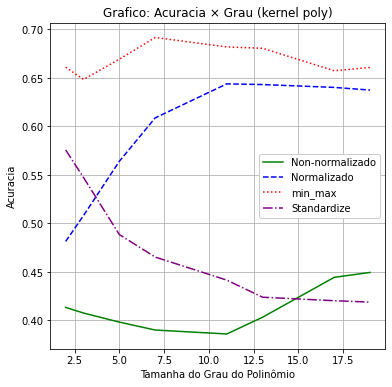

In [32]:
#Plot 
#plt.plot(acuracias_poly[:,0], acuracias_poly[:,1], color='g', label='acc')
plt.plot(acuracias_poly.iloc[:,0].values, [x.mean() for x in acuracias_poly.iloc[:,1].to_numpy()], color='g', label='Non-normalizado')
plt.plot(acuracias_norm_poly.iloc[:,0].values, [x.mean() for x in acuracias_norm_poly.iloc[:,1].to_numpy()], color='b' , linestyle='--', label='Normalizado')
plt.plot(acuracias_mm_poly.iloc[:,0].values, [x.mean() for x in acuracias_mm_poly.iloc[:,1].to_numpy()], color='r',linestyle=':', label='min_max')
plt.plot(acuracias_stand_poly.iloc[:,0].values, [x.mean() for x in acuracias_stand_poly.iloc[:,1].to_numpy()], color='purple',linestyle='-.', label='Standardize')

plt.ylabel('Acuracia')
plt.xlabel('Tamanha do Grau do Polinômio')
plt.title('Grafico: Acuracia × Grau (kernel poly)')
plt.legend(framealpha=1, frameon=True)
plt.grid(True)
plt.show()

### SVM Kernel Linear

#### Tarefa validação cruzada k-fold com dados brutos - Kernel Linear

In [33]:
#Treimando non-preprocessing
acuracias_linear = pd.DataFrame(valida_paremetros(C,X_train,y_train,kernel_='linear',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_linear)

      C                                          Acuracias
0     2  [0.5930252100840336, 0.5673109243697478, 0.599...
1     3  [0.5959663865546219, 0.5789915966386554, 0.611...
2     5  [0.6019327731092436, 0.5965546218487395, 0.611...
3     7  [0.6077310924369748, 0.6025210084033613, 0.599...
4    11  [0.6164705882352941, 0.6053781512605042, 0.605...
5    13  [0.6165546218487395, 0.602436974789916, 0.6084...
6    17  [0.6019327731092436, 0.6084033613445378, 0.602...
7    19  [0.6047899159663865, 0.6025210084033613, 0.602...
8    23  [0.5989075630252101, 0.5995798319327731, 0.602...
9    29  [0.5959663865546219, 0.5966386554621849, 0.599...
10   31  [0.5959663865546219, 0.5966386554621849, 0.599...
11   37  [0.5988235294117648, 0.5994957983193278, 0.602...
12   41  [0.5988235294117648, 0.602436974789916, 0.5997...
13   43  [0.6046218487394958, 0.602436974789916, 0.5938...
14   47  [0.6105042016806723, 0.6083193277310924, 0.599...
15   53  [0.607563025210084, 0.6112605042016807, 0.6055.

#### Tarefa validação cruzada k-fold com dados normalizados min-max - Kernel Linear

In [34]:
acuracias_mm_linear = pd.DataFrame(valida_paremetros(C,X_min_max_train.values,y_min_max_train,kernel_='linear',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_mm_linear)

      C                                          Acuracias
0     2  [0.5529556650246306, 0.5950738916256156, 0.570...
1     3  [0.5842364532019704, 0.5986453201970443, 0.591...
2     5  [0.5950738916256159, 0.6092364532019705, 0.616...
3     7  [0.6019704433497537, 0.6302955665024632, 0.640...
4    11  [0.6123152709359606, 0.644334975369458, 0.6259...
5    13  [0.6158866995073892, 0.6373152709359606, 0.633...
6    17  [0.6055418719211823, 0.6373152709359606, 0.629...
7    19  [0.6019704433497537, 0.6336206896551724, 0.629...
8    23  [0.5915024630541872, 0.6509852216748768, 0.626...
9    29  [0.5913793103448275, 0.6544334975369458, 0.622...
10   31  [0.5915024630541872, 0.6544334975369458, 0.629...
11   37  [0.5985221674876847, 0.6545566502463054, 0.626...
12   41  [0.5986453201970442, 0.6511083743842364, 0.622...
13   43  [0.5950738916256157, 0.6649014778325124, 0.622...
14   47  [0.6019704433497537, 0.6614532019704433, 0.622...
15   53  [0.601847290640394, 0.6649014778325124, 0.6261.

#### Tarefa validação cruzada k-fold com dados normalizados pela magnitude - Kernel Linear

In [35]:
acuracias_norm_linear = pd.DataFrame(valida_paremetros(C,X_norm_train.values,y_norm_train,kernel_='linear',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_norm_linear)

      C                                          Acuracias
0     2  [0.30825123152709366, 0.31477832512315274, 0.3...
1     3  [0.30825123152709366, 0.31477832512315274, 0.3...
2     5  [0.30825123152709366, 0.31477832512315274, 0.3...
3     7  [0.30825123152709366, 0.31477832512315274, 0.3...
4    11  [0.30825123152709366, 0.31477832512315274, 0.3...
5    13  [0.30825123152709366, 0.31477832512315274, 0.3...
6    17  [0.30825123152709366, 0.31477832512315274, 0.3...
7    19  [0.29396551724137937, 0.31477832512315274, 0.3...
8    23  [0.29396551724137937, 0.31822660098522165, 0.3...
9    29  [0.3045566502463054, 0.31822660098522165, 0.31...
10   31  [0.3151477832512316, 0.3320197044334975, 0.321...
11   37  [0.33633004926108373, 0.35665024630541875, 0.3...
12   41  [0.3571428571428571, 0.3951970443349754, 0.359...
13   43  [0.3571428571428571, 0.4023399014778325, 0.366...
14   47  [0.367487684729064, 0.40258620689655167, 0.380...
15   53  [0.39507389162561574, 0.41982758620689653, 0.3.

#### Tarefa validação cruzada k-fold com dados padronizados - Kernel Linear

In [36]:
acuracias_stand_linear = pd.DataFrame(valida_paremetros(C,X_stand_train.values,y_stand_train,kernel_='linear',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_stand_linear)

      C                                          Acuracias
0     2  [0.636576354679803, 0.671551724137931, 0.63965...
1     3  [0.6541871921182267, 0.6713054187192118, 0.639...
2     5  [0.6432266009852217, 0.6748768472906403, 0.639...
3     7  [0.6327586206896553, 0.6576354679802956, 0.632...
4    11  [0.6293103448275862, 0.6469211822660099, 0.635...
5    13  [0.6189655172413793, 0.6573891625615763, 0.635...
6    17  [0.6258620689655172, 0.6469211822660099, 0.632...
7    19  [0.6257389162561575, 0.6435960591133005, 0.629...
8    23  [0.6326354679802955, 0.6401477832512315, 0.632...
9    29  [0.6293103448275862, 0.6401477832512315, 0.625...
10   31  [0.6293103448275862, 0.6366995073891626, 0.632...
11   37  [0.6222906403940885, 0.6402709359605911, 0.632...
12   41  [0.6222906403940885, 0.6402709359605911, 0.628...
13   43  [0.6188423645320197, 0.6402709359605911, 0.632...
14   47  [0.6188423645320197, 0.64371921182266, 0.62894...
15   53  [0.6222906403940887, 0.647167487684729, 0.6323.

#### Resultados da valiação cruzada para o modelo SVM com Kernel Linear

O gráfico a seguir apresenta os resultados da tarefa de validação cruzada para o SVM com kernel Linear, para cada valor do parâmetro $C$. Neste cenário observamos que desepenho do modelo com dados padronizados e normalizados com min-max competem conforme a variação do valor do parâmetro $C$. Quanto maior o valor do parâmetro $C$, o modelo com dados normalizados min-max, superam o modelo com os dados padronizados.

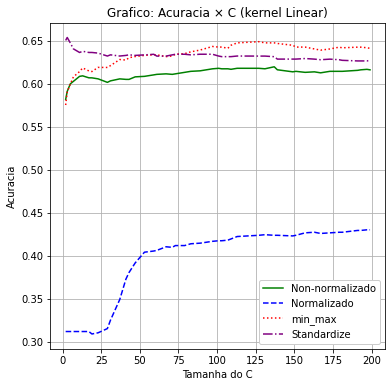

In [37]:
#Plot 
plt.plot(acuracias_linear.iloc[:,0].values, [x.mean() for x in acuracias_linear.iloc[:,1].to_numpy()], color='g', label='Non-normalizado')
plt.plot(acuracias_norm_linear.iloc[:,0].values, [x.mean() for x in acuracias_norm_linear.iloc[:,1].to_numpy()], color='b' , linestyle='--', label='Normalizado')
plt.plot(acuracias_mm_linear.iloc[:,0].values, [x.mean() for x in acuracias_mm_linear.iloc[:,1].to_numpy()], color='r',linestyle=':', label='min_max')
plt.rcParams["figure.figsize"] = (7,7)
plt.plot(acuracias_stand_linear.iloc[:,0].values, [x.mean() for x in acuracias_stand_linear.iloc[:,1].to_numpy()], color='purple',linestyle='-.', label='Standardize')
plt.ylabel('Acuracia')
plt.xlabel('Tamanha do C')
plt.title('Grafico: Acuracia × C (kernel Linear)')
plt.grid(True)
plt.legend(framealpha=1, frameon=True)
plt.show()

### SVM - Sigmoid

#### Tarefa validação cruzada k-fold com dados brutos - Kernel Sigmoid

In [38]:
acuracias_sigmoid = pd.DataFrame(valida_paremetros(C,X_train,y_train,kernel_='sigmoid',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_sigmoid)

      C                                          Acuracias
0     2  [0.33613445378151263, 0.32731092436974796, 0.3...
1     3  [0.33613445378151263, 0.32731092436974796, 0.3...
2     5  [0.33613445378151263, 0.32731092436974796, 0.3...
3     7  [0.33613445378151263, 0.32731092436974796, 0.3...
4    11  [0.33613445378151263, 0.32731092436974796, 0.3...
5    13  [0.33613445378151263, 0.32731092436974796, 0.3...
6    17  [0.33613445378151263, 0.32731092436974796, 0.3...
7    19  [0.33613445378151263, 0.32731092436974796, 0.3...
8    23  [0.33613445378151263, 0.32731092436974796, 0.3...
9    29  [0.33613445378151263, 0.32731092436974796, 0.3...
10   31  [0.33613445378151263, 0.32731092436974796, 0.3...
11   37  [0.33613445378151263, 0.32731092436974796, 0.3...
12   41  [0.33613445378151263, 0.32731092436974796, 0.3...
13   43  [0.33613445378151263, 0.32731092436974796, 0.3...
14   47  [0.33613445378151263, 0.32731092436974796, 0.3...
15   53  [0.33613445378151263, 0.32731092436974796, 0.3.

#### Tarefa validação cruzada k-fold com dados normalizados min-max - Kernel Sigmoid

In [39]:
acuracias_mm_sigmoid = pd.DataFrame(valida_paremetros(C,X_min_max_train.values,y_min_max_train,kernel_='sigmoid',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_mm_sigmoid)

      C                                          Acuracias
0     2  [0.4268472906403941, 0.47573891625615766, 0.43...
1     3  [0.4268472906403941, 0.46182266009852224, 0.42...
2     5  [0.42007389162561576, 0.4098522167487685, 0.41...
3     7  [0.40591133004926105, 0.45800492610837445, 0.3...
4    11  [0.40615763546798034, 0.4264778325123153, 0.40...
5    13  [0.4097290640394089, 0.43349753694581283, 0.43...
6    17  [0.41342364532019704, 0.42660098522167483, 0.4...
7    19  [0.4098522167487685, 0.43349753694581283, 0.42...
8    23  [0.4062807881773399, 0.4266009852216749, 0.410...
9    29  [0.4062807881773399, 0.4336206896551724, 0.406...
10   31  [0.4097290640394089, 0.43004926108374386, 0.42...
11   37  [0.4097290640394089, 0.4302955665024631, 0.427...
12   41  [0.41317733990147787, 0.43386699507389165, 0.4...
13   43  [0.41317733990147787, 0.43731527093596056, 0.4...
14   47  [0.4061576354679802, 0.4443349753694581, 0.420...
15   53  [0.4096059113300492, 0.4336206896551724, 0.417.

#### Tarefa validação cruzada k-fold com dados normalizados pela magnitude - Kernel Sigmoid

In [40]:
acuracias_norm_sigmoid = pd.DataFrame(valida_paremetros(C,X_norm_train.values,y_norm_train,kernel_='sigmoid',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_norm_sigmoid)

      C                                          Acuracias
0     2  [0.30825123152709366, 0.31477832512315274, 0.3...
1     3  [0.30825123152709366, 0.31477832512315274, 0.3...
2     5  [0.30825123152709366, 0.31477832512315274, 0.3...
3     7  [0.30825123152709366, 0.31477832512315274, 0.3...
4    11  [0.30825123152709366, 0.31477832512315274, 0.3...
5    13  [0.30825123152709366, 0.31477832512315274, 0.3...
6    17  [0.30825123152709366, 0.31477832512315274, 0.3...
7    19  [0.30825123152709366, 0.31477832512315274, 0.3...
8    23  [0.30825123152709366, 0.31477832512315274, 0.3...
9    29  [0.30825123152709366, 0.31477832512315274, 0.3...
10   31  [0.30825123152709366, 0.31477832512315274, 0.3...
11   37  [0.30825123152709366, 0.31477832512315274, 0.3...
12   41  [0.30825123152709366, 0.31477832512315274, 0.3...
13   43  [0.30825123152709366, 0.31477832512315274, 0.3...
14   47  [0.30825123152709366, 0.31477832512315274, 0.3...
15   53  [0.30825123152709366, 0.31477832512315274, 0.3.

#### Tarefa validação cruzada k-fold com dados padronizados - Kernel Sigmoid

In [41]:
acuracias_stand_sigmoid = pd.DataFrame(valida_paremetros(C,X_stand_train.values,y_stand_train,kernel_='sigmoid',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_stand_sigmoid)

      C                                          Acuracias
0     2  [0.5283251231527093, 0.5392857142857143, 0.514...
1     3  [0.5110837438423645, 0.5529556650246304, 0.521...
2     5  [0.5112068965517241, 0.5141625615763546, 0.496...
3     7  [0.49716748768472907, 0.5178571428571428, 0.47...
4    11  [0.48977832512315267, 0.5002463054187192, 0.45...
5    13  [0.483128078817734, 0.48977832512315267, 0.440...
6    17  [0.4550492610837439, 0.49642857142857133, 0.45...
7    19  [0.46194581280788183, 0.4858374384236453, 0.45...
8    23  [0.44790640394088677, 0.4752463054187192, 0.44...
9    29  [0.4513546798029557, 0.48903940886699504, 0.45...
10   31  [0.44790640394088677, 0.4752463054187192, 0.45...
11   37  [0.4583743842364532, 0.4820197044334975, 0.465...
12   41  [0.47586206896551725, 0.47857142857142854, 0.4...
13   43  [0.4722906403940887, 0.4817733990147783, 0.433...
14   47  [0.4619458128078818, 0.47155172413793106, 0.43...
15   53  [0.46551724137931033, 0.475, 0.426600985221674.

### Resultados da valiação cruzada para o modelo SVM com Kernel Sigmoid

O gráfico a seguir apresenta os resultados da tarefa de validação cruzada para o SVM com kernel Sigmoid, para cada valor do parâmetro $C$. Observa-se, neste cenário, que o modelo com dados padronizados apresenta, os melhores resultados independente do valor do parâmetro $C$. Porém a acurácia vai reduzindo conforme aumenta o valor de $C$. Com kernel sigmoid é possível selecionar um bom modelo de classificação com baixo valor de $C$, deixando o modelo menos especializado e com menos chance de overfitting.

Vale destacar que, o modelo com os dados brutos, a acurácia cresce a medida que aumenta o valor de $C$, ao ponto de ficar bem proximo do valor com daods padronizados. No entanto, não é indicado usar este modelo porque ele deve apresentar overfitting.


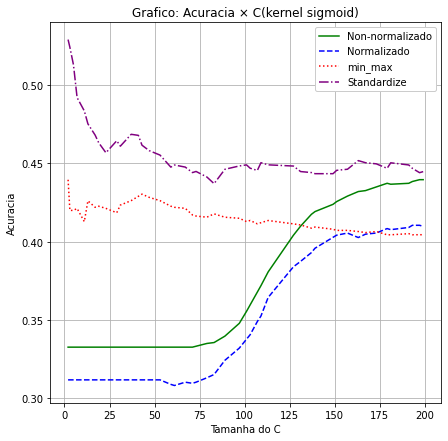

In [42]:
#Plot 
plt.plot(acuracias_sigmoid.iloc[:,0].values, [x.mean() for x in acuracias_sigmoid.iloc[:,1].to_numpy()], color='g', label='Non-normalizado')
plt.plot(acuracias_norm_sigmoid.iloc[:,0].values, [x.mean() for x in acuracias_norm_sigmoid.iloc[:,1].to_numpy()], color='b' , linestyle='--', label='Normalizado')
plt.plot(acuracias_mm_sigmoid.iloc[:,0].values, [x.mean() for x in acuracias_mm_sigmoid.iloc[:,1].to_numpy()], color='r',linestyle=':', label='min_max')

plt.plot(acuracias_stand_sigmoid.iloc[:,0].values, [x.mean() for x in acuracias_stand_sigmoid.iloc[:,1].to_numpy()], color='purple',linestyle='-.', label='Standardize')
plt.ylabel('Acuracia')
plt.xlabel('Tamanha do C')
plt.title('Grafico: Acuracia × C(kernel sigmoid)')
plt.grid(True)
plt.legend(framealpha=1, frameon=True)
plt.show()

## Resultados Finais 

Ajuste dos modelos com os melhores valores dos parâmetros selecionados através da validação cruzada. E aplicado ao conjunto de teste ainda não utilizado, para validar a capacidade de predição do modelo final em um conjunto de dados novos.

O valor do parametro $C$ foi selecionado a partir do modelo que apresentou melhor acurácia.

In [43]:
#RBF
C_max_non_norm = acuracias.iloc[np.argmax(np.array([x.mean() for x in acuracias.iloc[:,1].to_numpy()])),0]
C_max_min_max = acuracias_mm.iloc[np.argmax(np.array([x.mean() for x in acuracias_mm.iloc[:,1].to_numpy()])),0]
C_max_norm = acuracias_norm.iloc[np.argmax(np.array([x.mean() for x in acuracias_norm.iloc[:,1].to_numpy()])),0]
C_max_stand = acuracias_stand.iloc[np.argmax(np.array([x.mean() for x in acuracias_stand.iloc[:,1].to_numpy()])),0]

#Grau poly
d_max_non_norm = acuracias_poly.iloc[np.argmax(np.array([x.mean() for x in acuracias_poly.iloc[:,1].to_numpy()])),0]
d_max_min_max = acuracias_mm_poly.iloc[np.argmax(np.array([x.mean() for x in acuracias_mm_poly.iloc[:,1].to_numpy()])),0]
d_max_norm = acuracias_norm_poly.iloc[np.argmax(np.array([x.mean() for x in acuracias_norm_poly.iloc[:,1].to_numpy()])),0]
d_max_stand = acuracias_stand_poly.iloc[np.argmax(np.array([x.mean() for x in acuracias_stand_poly.iloc[:,1].to_numpy()])),0]

#Linear
C_max_non_norm_linear = acuracias_linear.iloc[np.argmax(np.array([x.mean() for x in acuracias_linear.iloc[:,1].to_numpy()])),0]
C_max_min_max_linear = acuracias_mm_linear.iloc[np.argmax(np.array([x.mean() for x in acuracias_mm_linear.iloc[:,1].to_numpy()])),0]
C_max_norm_linear = acuracias_norm_linear.iloc[np.argmax(np.array([x.mean() for x in acuracias_norm_linear.iloc[:,1].to_numpy()])),0]
C_max_stand_linear = acuracias_stand_linear.iloc[np.argmax(np.array([x.mean() for x in acuracias_stand_linear.iloc[:,1].to_numpy()])),0]

#Sigmoid
C_max_non_norm_sigmoid = acuracias_sigmoid.iloc[np.argmax(np.array([x.mean() for x in acuracias_sigmoid.iloc[:,1].to_numpy()])),0]
C_max_min_max_sigmoid = acuracias_mm_sigmoid.iloc[np.argmax(np.array([x.mean() for x in acuracias_mm_sigmoid.iloc[:,1].to_numpy()])),0]
C_max_norm_sigmoid = acuracias_norm_sigmoid.iloc[np.argmax(np.array([x.mean() for x in acuracias_norm_sigmoid.iloc[:,1].to_numpy()])),0]
C_max_stand_sigmoid = acuracias_stand_sigmoid.iloc[np.argmax(np.array([x.mean() for x in acuracias_stand_sigmoid.iloc[:,1].to_numpy()])),0]

print('Parametros Separados')

Parametros Separados


In [44]:
#classificador para base não processada
clf_rbf_non = svm.SVC(C=C_max_non_norm)
clf_poly_non = svm.SVC(C=C_max_non_norm,degree=d_max_non_norm)
clf_linear_non = svm.SVC(C=C_max_non_norm_linear)
clf_sig_non = svm.SVC(C=C_max_non_norm_sigmoid)

#classificador para base normalizada
clf_rbf_norm = svm.SVC(C=C_max_norm)
clf_poly_norm = svm.SVC(C=C_max_norm,degree=d_max_min_max)
clf_linear_norm = svm.SVC(C=C_max_min_max_linear)
clf_sig_norm = svm.SVC(C=C_max_stand_sigmoid)

#classificador para base Min_max
clf_rbf_mm = svm.SVC(C=C_max_min_max)
clf_poly_mm = svm.SVC(C=C_max_min_max,degree=d_max_stand)
clf_linear_mm = svm.SVC(C=C_max_norm_linear)
clf_sig_mm = svm.SVC(C=C_max_norm_sigmoid)

#classificador para base stand
clf_rbf_stand = svm.SVC(C=C_max_stand)
clf_poly_stand = svm.SVC(C=C_max_stand,degree=d_max_stand)
clf_linear_stand = svm.SVC(C=C_max_stand_linear)
clf_sig_stand = svm.SVC(C=C_max_stand_sigmoid)


print('Inicalizacao dos classificadores com os paremetros validados')

Inicalizacao dos classificadores com os paremetros validados


In [45]:
#ajuste para base non
clf_rbf_non.fit(X_train, y_train)
clf_poly_non.fit(X_train, y_train)
clf_linear_non.fit(X_train, y_train)
clf_sig_non.fit(X_train, y_train)

clf_rbf_norm.fit(X_norm_train,y_norm_train)
clf_poly_norm.fit(X_norm_train,y_norm_train)
clf_linear_norm.fit(X_norm_train,y_norm_train)
clf_sig_norm.fit(X_norm_train,y_norm_train)

#classificador p
clf_rbf_mm.fit(X_min_max_train,y_min_max_train)
clf_poly_mm.fit(X_min_max_train,y_min_max_train)
clf_linear_mm.fit(X_min_max_train,y_min_max_train)
clf_sig_mm.fit(X_min_max_train,y_min_max_train)

#classificador p
clf_rbf_stand.fit(X_stand_train,y_stand_train)
clf_poly_stand.fit(X_stand_train,y_stand_train)
clf_linear_stand.fit(X_stand_train,y_stand_train)
clf_sig_stand.fit(X_stand_train,y_stand_train)
print('Modelos treinados')

Modelos treinados


In [46]:
y_non_svm_rbf = clf_rbf_non.predict(X_test)
y_non_svm_poly = clf_poly_non.predict(X_test)
y_non_svm_lin = clf_linear_non.predict(X_test)
y_non_svm_sig = clf_sig_non.predict(X_test)

y_norm_svm_rbf =clf_rbf_norm.predict(X_norm_test)
y_norm_svm_poly = clf_poly_norm.predict(X_norm_test)
y_norm_svm_lin = clf_linear_norm.predict(X_norm_test)
y_norm_svm_sig = clf_sig_norm.predict(X_norm_test)

y_mm_svm_rbf = clf_rbf_mm.predict(X_min_max_test)
y_mm_svm_poly = clf_poly_mm.predict(X_min_max_test)
y_mm_svm_lin = clf_linear_mm.predict(X_min_max_test)
y_mm_svm_sig = clf_sig_mm.predict(X_min_max_test)

y_stand_svm_rbf =  clf_rbf_stand.predict(X_stand_test)
y_stand_svm_poly = clf_poly_stand.predict(X_stand_test)
y_stand_svm_lin = clf_linear_stand.predict(X_stand_test)
y_stand_svm_sig = clf_sig_stand.predict(X_stand_test)

print('Predicao')

Predicao


### Avaliação dos modelos no conjunto de teste.

In [47]:
y_knn_non = knn.fit(X_train, y_train).predict(X_test)
y_reg_non = reg.fit(X_train, y_train).predict(X_test)
y_gnb_non = gnb.fit(X_train, y_train).predict(X_test)

y_knn_norm = knn.fit(X_norm_train, y_norm_train).predict(X_norm_test)
y_reg_norm = reg.fit(X_norm_train, y_norm_train).predict(X_norm_test)
y_gnb_norm = gnb.fit(X_norm_train, y_norm_train).predict(X_norm_test)

y_knn_mm = knn.fit(X_min_max_train, y_min_max_train).predict(X_min_max_test)
y_reg_mm = reg.fit(X_min_max_train, y_min_max_train).predict(X_min_max_test)
y_gnb_mm = gnb.fit(X_min_max_train, y_min_max_train).predict(X_min_max_test)

y_knn_stand = knn.fit(X_stand_train, y_stand_train).predict(X_stand_test)
y_reg_stand = reg.fit(X_stand_train, y_stand_train).predict(X_stand_test)
y_gnd_stand = gnb.fit(X_stand_train, y_stand_train).predict(X_stand_test)


In [48]:
#aux para armazenhar as metricas 
metricas_non = [accuracy_score(y_test, y_knn_non), accuracy_score(y_test, y_gnb_non), accuracy_score(y_test, y_reg_non), accuracy_score(y_test, y_non_svm_rbf), accuracy_score(y_test, y_non_svm_poly),  accuracy_score(y_test, y_non_svm_lin), accuracy_score(y_test, y_non_svm_sig)]

metricas_norm = [accuracy_score(y_norm_test, y_knn_norm), accuracy_score(y_norm_test, y_gnb_norm), accuracy_score(y_norm_test, y_reg_norm), accuracy_score(y_norm_test, y_norm_svm_rbf), accuracy_score(y_norm_test, y_norm_svm_poly),  accuracy_score(y_norm_test, y_norm_svm_lin), accuracy_score(y_norm_test, y_norm_svm_sig)]

metricas_mm = [accuracy_score(y_min_max_test, y_knn_mm), accuracy_score(y_min_max_test, y_reg_mm), accuracy_score(y_min_max_test, y_reg_mm), accuracy_score(y_min_max_test, y_mm_svm_rbf), accuracy_score(y_min_max_test, y_mm_svm_poly),  accuracy_score(y_min_max_test, y_mm_svm_lin), accuracy_score(y_min_max_test, y_mm_svm_sig)]

metricas_stand = [accuracy_score(y_stand_test, y_knn_stand), accuracy_score(y_stand_test, y_gnd_stand), accuracy_score(y_stand_test, y_reg_stand), accuracy_score(y_stand_test, y_stand_svm_rbf), accuracy_score(y_stand_test, y_stand_svm_poly),  accuracy_score(y_stand_test, y_stand_svm_lin), accuracy_score(y_stand_test, y_stand_svm_sig)]

## Conclusões Finais

Os gráficos abaixo apresentam os resultados dos modelos no conjunto de teste para os diferentes cenários. 

Pode-se concluir que os modelos baseados em SVM devem ser utilizados com dados padronizados, pois nestes casos apresentaram os melhores desempenhos com baixo valor do parâmetro $C$, independente da função kernel. Assim, o modelo apresenta uma melhor capacidade de generalização.

Os modelos usando os dados normalizados por min-max com kernel Polinomial e RBF, apresentaram desempenho semelhante aos do kernel RBF, também com baixos valores do parâmetro $C$.

No geral, para este problema o melhor modelo foi o $k$-NN com os dados brutos.



In [49]:
print('Parametro C para cara base com Kernel RBF')
print('Melher C base não normalizada: ',C_max_non_norm)
print('Melher C base normalizados min-max: ',C_max_min_max)
print('Melher C base normalizados pela magnitude:' ,C_max_norm)
print('Melher C base padronizada: ',C_max_stand)
print('─'*50)

print('Parametro Grau para cara base com Kernel Polinomial e C igual ao do RBF')
print('Melher Grau base não normalizada: ',d_max_non_norm)
print('Melher Grau base normalizados min-max: ',d_max_min_max)
print('Melher Grau base normalizados pela magnitude:' ,d_max_norm)
print('Melher Grau base padronizada: ',d_max_stand)
print('─'*50)

print('Parametro C para cara base com Kernel linear')
print('Melher C base não normalizada: ',C_max_non_norm_linear)
print('Melher C base normalizados min-max: ',C_max_min_max_linear)
print('Melher C base normalizados pela magnitude: ',C_max_norm_linear)
print('Melher C base padronizada: ',C_max_stand_linear)
print('─'*50)

print('Parametro C para cara base com Kernel sigmoid')
print('Melher C base não normalizada: ',C_max_non_norm_sigmoid)
print('Melher C base normalizados min-max: ',C_max_min_max_sigmoid )
print('Melher C base normalizados pela magnitude: ',C_max_norm_sigmoid)
print('Melher C base padronizada: ',C_max_stand_sigmoid)
print('─'*50)

Parametro C para cara base com Kernel RBF
Melher C base não normalizada:  163
Melher C base normalizados min-max:  5
Melher C base normalizados pela magnitude: 199
Melher C base padronizada:  5
──────────────────────────────────────────────────
Parametro Grau para cara base com Kernel Polinomial e C igual ao do RBF
Melher Grau base não normalizada:  19
Melher Grau base normalizados min-max:  7
Melher Grau base normalizados pela magnitude: 11
Melher Grau base padronizada:  2
──────────────────────────────────────────────────
Parametro C para cara base com Kernel linear
Melher C base não normalizada:  137
Melher C base normalizados min-max:  127
Melher C base normalizados pela magnitude:  197
Melher C base padronizada:  3
──────────────────────────────────────────────────
Parametro C para cara base com Kernel sigmoid
Melher C base não normalizada:  197
Melher C base normalizados min-max:  2
Melher C base normalizados pela magnitude:  193
Melher C base padronizada:  2
────────────────────

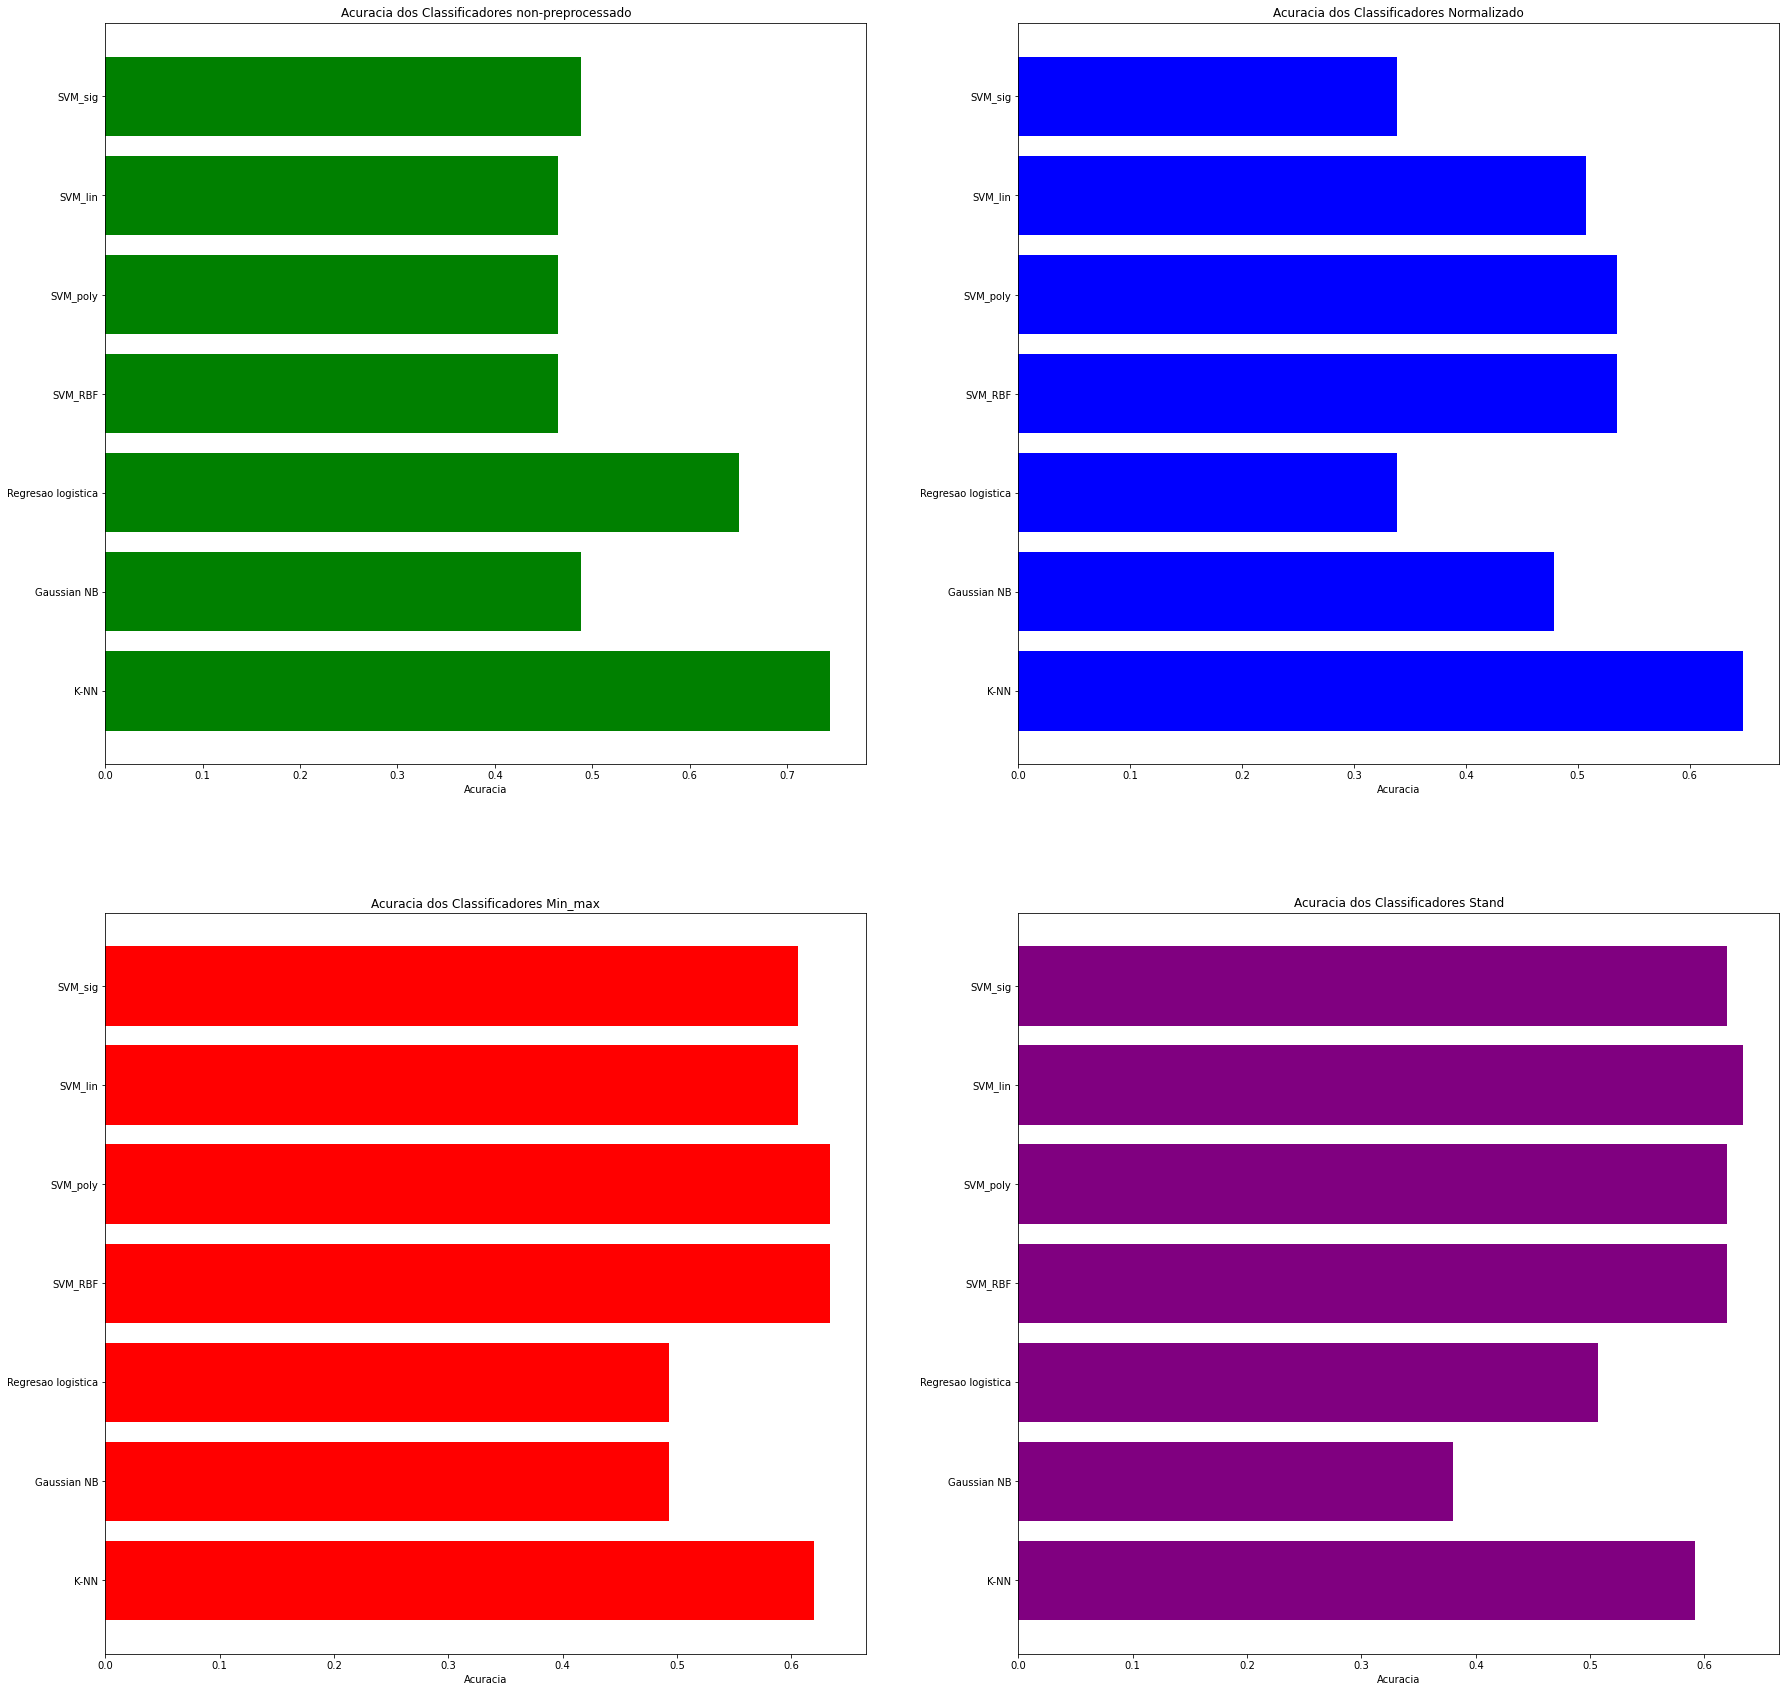

In [50]:
## Grafico de acuracia
nome_classificadores = ['K-NN', 'Gaussian NB', 'Regresao logistica','SVM_RBF', 'SVM_poly', 'SVM_lin', 'SVM_sig']
plt.rcParams["figure.figsize"] = (30,30)
fig, axs = plt.subplots(2,2)
axs[0][0].set_title('Acuracia dos Classificadores non-preprocessado')
axs[0][0].barh(nome_classificadores, metricas_non, color='g')
axs[0][0].set_xlabel('Acuracia')

axs[0][1].set_title('Acuracia dos Classificadores Normalizado')
axs[0][1].barh(nome_classificadores, metricas_norm, color='b')
axs[0][1].set_xlabel('Acuracia')

axs[1][0].set_title('Acuracia dos Classificadores Min_max')
axs[1][0].barh(nome_classificadores, metricas_mm, color='r')
axs[1][0].set_xlabel('Acuracia')

axs[1][1].set_title('Acuracia dos Classificadores Stand')
axs[1][1].barh(nome_classificadores, metricas_stand, color='purple')
axs[1][1].set_xlabel('Acuracia')

plt.show()

#Referencias

1. Um guia completo para o pré-processamento de dados em machine learning -  https://caiquecoelho.medium.com/um-guia-completo-para-o-pr%C3%A9-processamento-de-dados-em-machine-learning-f860fbadabe1 
1. Magnitude e normalização de vetores - https://pt.khanacademy.org/computing/computer-programming/programming-natural-simulations/programming-vectors/a/vector-magnitude-normalization#:~:text=Em%20outras%20palavras%2C%20para%20normalizar,5%20sobre%205%20%C3%A9%201.
1. Kernel functions, scikit learn -  https://scikit-learn.org/stable/modules/svm.html#svm-kernels